In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.colors
import random
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
random.seed(3108)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Data** **Prepocessing**

In [3]:
rawData = pd.read_csv('gdrive/My Drive/Intro to DS/2023_LoL_esports_match_data_from_OraclesElixir.csv')
rawData.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,...,131.0,322.0,263.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,...,117.0,-357.0,-1323.0,-43.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,...,162.0,-479.0,-324.0,-26.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,...,122.0,200.0,292.0,20.0,0.0,0.0,0.0,1.0,0.0,0.0
4,ESPORTSTMNT06_2753012,complete,NaN,LFL2,2023,Spring,0,2023-01-10 17:07:16,1,13.01,...,3.0,-216.0,-579.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [4]:
data_1 = rawData[(rawData['position'] == 'team') & (rawData['datacompleteness'] == 'complete')]
print(data_1.shape)

(18448, 123)


In [5]:
def readFile(path):
    with open(path, 'rt') as f:
        return f.read()

In [6]:
selectedVars_file = readFile('gdrive/My Drive/Intro to DS/vars_selection.txt')
selectedVars = list()
for varName in selectedVars_file.splitlines():
    selectedVars.append(varName)

# 95 variables selected for the analysis
data_1 = data_1[selectedVars]
print(data_1.shape)

(18448, 99)


In [7]:
data_1.head()

,patch,side,gamelength,result,kills,deaths,assists,doublekills,triplekills,quadrakills,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
10,13.01,Blue,2612,1,13,7,38,1.0,1.0,0.0,...,535.0,-530.0,-1671.0,-37.0,0.0,0.0,1.0,1.0,1.0,0.0
11,13.01,Red,2612,0,7,13,18,1.0,0.0,0.0,...,498.0,530.0,1671.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0
22,13.01,Blue,2436,0,20,16,44,2.0,0.0,0.0,...,532.0,673.0,530.0,-34.0,4.0,6.0,3.0,3.0,4.0,4.0
23,13.01,Red,2436,1,16,20,28,1.0,0.0,0.0,...,498.0,-673.0,-530.0,34.0,3.0,4.0,4.0,4.0,6.0,3.0
34,13.01,Blue,1980,1,20,7,48,2.0,2.0,0.0,...,452.0,-1901.0,-763.0,58.0,2.0,1.0,4.0,4.0,6.0,2.0


In [8]:
def checkMissing(dataFrame):
    missingVars = dict()
    for var in dataFrame.columns.values:
        missingCount = dataFrame[var].isnull().sum()
        if missingCount > 0:
            missingVars[var] = missingCount
    if len(missingVars) == 0:
        print('No missing entries in the dataframe.')
    return missingVars
checkMissing(data_1)

{'firstbloodkill': 18448,
 'firstbloodassist': 18448,
 'dragons (type unknown)': 18448,
 'damageshare': 18448,
 'earnedgoldshare': 18448,
 'total cs': 18448,
 'monsterkillsownjungle': 18448,
 'monsterkillsenemyjungle': 18448}

In [9]:
# delete specified columns
data_2 = data_1.drop(['dragons (type unknown)', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'firstbloodkill', 'firstbloodassist', 'damageshare', 'earnedgoldshare', 'total cs'], axis=1)

# filter rows with missing values in specific columns
droppedData = data_2[(data_2['elementaldrakes'].isnull()) | (data_2['firstmidtower'].isnull())]

# check whether the 88 missing entries came from the same 88 rows
def checkSameGames(dataFrame):
    rowsWithIssues = list()
    for i in range(dataFrame.shape[0],2):
        gameLength_1 = dataFrame.iloc[i, 3]  # "gamelength" index = 3
        gameLength_2 = dataFrame.iloc[i + 1, 3]
        if gameLength_1 != gameLength_2:
            rowsWithIssues.append(i)
    if len(rowsWithIssues) == 0:
        print("All dropped rows belong to the same set of games")
        return True
    else:
        return rowsWithIssues

# perform the check before dropping rows
checkSameGames(data_2)

# drop rows with NaN values in specified columns
data_2 = data_2.dropna(subset=['elementaldrakes', 'firstmidtower'])

# check for missing entries after dropping rows
checkMissing(data_2)

# reset index
data_3 = data_2.reset_index()
data_3.rename(columns={"index": "old index"}, inplace=True)



All dropped rows belong to the same set of games
No missing entries in the dataframe.


In [10]:
data_3.shape
data_3.head()

,old index,patch,side,gamelength,result,kills,deaths,assists,doublekills,triplekills,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,10,13.01,Blue,2612,1,13,7,38,1.0,1.0,...,535.0,-530.0,-1671.0,-37.0,0.0,0.0,1.0,1.0,1.0,0.0
1,11,13.01,Red,2612,0,7,13,18,1.0,0.0,...,498.0,530.0,1671.0,37.0,1.0,1.0,0.0,0.0,0.0,1.0
2,22,13.01,Blue,2436,0,20,16,44,2.0,0.0,...,532.0,673.0,530.0,-34.0,4.0,6.0,3.0,3.0,4.0,4.0
3,23,13.01,Red,2436,1,16,20,28,1.0,0.0,...,498.0,-673.0,-530.0,34.0,3.0,4.0,4.0,4.0,6.0,3.0
4,34,13.01,Blue,1980,1,20,7,48,2.0,2.0,...,452.0,-1901.0,-763.0,58.0,2.0,1.0,4.0,4.0,6.0,2.0


In [11]:
# identify different types of variables
allFeatures = data_3.columns.values[1:]
textVars = ['side','patch']
binaryVars = ['result','firstblood','firstdragon','firstherald','firstbaron','firsttower','firstmidtower','firsttothreetowers']
numericVars = [var for var in allFeatures if (var not in textVars) & (var not in binaryVars)]
textData = data_3[textVars]
binaryData = data_3[binaryVars]
numericData = data_3[numericVars]

<Figure size 1200x1200 with 0 Axes>

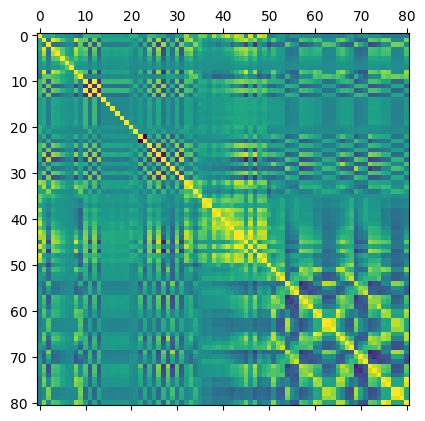

In [12]:
# draw correlation matrix
plt.figure(figsize=(12,12))
plt.matshow(numericData.corr())
plt.show()

**Inference**

In [13]:
data_infer = data_3[["patch","side","result"]]
data_infer.isna().sum()

patch     0
side      0
result    0
dtype: int64

In [14]:
def RandomPickOne(data):
    n = data.shape[0]
    index = np.arange(0,n,2)+np.random.binomial(1,0.5,n//2)
    return data.iloc[index,:]
## do Chi-square for data:
def ChiSquareTest(data):
    sub = RandomPickOne(data)
    table = pd.crosstab(sub["side"], sub["result"], margins=False)
    return chi2_contingency(table)

In [15]:
# Global Analysis
blue = data_infer.shape[0]//2
bluewin = sum(data_infer[data_infer["side"]=="Blue"]["result"])
print(bluewin/blue*100)

53.41500433651344


In [16]:
sub = RandomPickOne(data_infer)
table_all = pd.crosstab(sub["side"], sub["result"], margins=True)
table = pd.crosstab(sub["side"], sub["result"], margins=False)
table_all

result,0,1,All
side,,,
Blue,2105,2509,4614
Red,2418,2192,4610
All,4523,4701,9224


In [17]:
# Chi-Square using the table above (same randomly-picked dataset)
chi2_contingency(table)

Chi2ContingencyResult(statistic=42.76171010147484, pvalue=6.183064230143993e-11, dof=1, expected_freq=array([[2262.48070252, 2351.51929748],
       [2260.51929748, 2349.48070252]]))

In [18]:
## for each patch
patch_table = pd.DataFrame(data_3.groupby("patch").size())
patch_table.columns =["Number"]
patches = patch_table.index
pvalues = []
bluewinrate =[]
for patch in patches:
    data = data_infer[data_infer["patch"]==patch]
    blue = data.shape[0]//2
    bluewin = sum(data[data["side"]=="Blue"]["result"])
    bluewinrate.append(bluewin/blue*100)
    v,p = ChiSquareTest(data)[0:2]
    pvalues.append(p)
patch_table["BlueWinRate"] = bluewinrate
patch_table["p-value"] = pvalues
patch_table["Number"] = patch_table["Number"]//2

In [19]:
patch_table.iloc[:21,:]

,Number,BlueWinRate,p-value
patch,,,
13.01,1571,52.641630,0.041066
13.03,758,54.617414,0.013296
13.04,823,52.855407,0.126166
13.05,756,55.158730,0.004459
13.06,266,50.375940,0.991880
13.07,43,55.813953,0.616628
13.08,188,47.872340,0.670354
13.09,25,44.000000,0.834969
13.10,372,51.344086,0.679097


In [20]:
### plot rate
blue_cmap = plt.cm.get_cmap('Blues_r')
red_cmap = plt.cm.get_cmap('Reds_r')
color = []
colorline = [x**0.2-0.2 for x in pvalues]
for i in range(21):
    if patch_table.iloc[i,1]<50:
        color.append(red_cmap(colorline[i]))
    else:
        color.append(blue_cmap(colorline[i]))

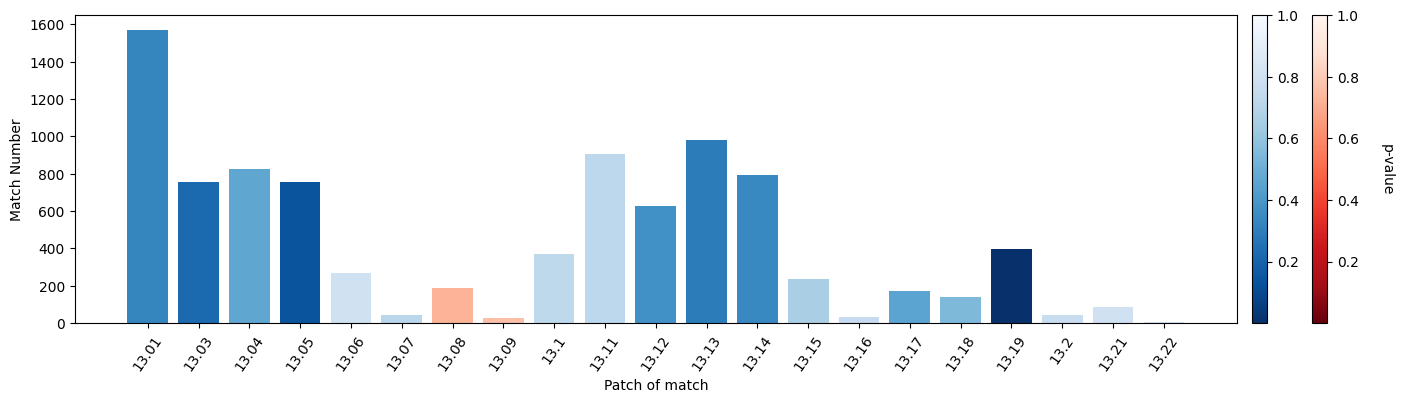

In [21]:
from matplotlib.cm import ScalarMappable
fig, ax = plt.subplots(figsize=(15, 4))
## bar plot
bars = ax.bar(patch_table.index.astype("str"),patch_table["Number"], color=color)
#ax.bar_label(bars,["*"if x<0.05 else "" for x in patch_table["p-value"]], size="x-large")

## color bar
sm = ScalarMappable(cmap=blue_cmap, norm=plt.Normalize(min(pvalues),max(pvalues)))
sm.set_array([])
position = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.010, ax.get_position().height])
cbar = plt.colorbar(sm,cax=position)
sm = ScalarMappable(cmap=red_cmap, norm=plt.Normalize(min(pvalues),max(pvalues)))
sm.set_array([])
position = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0,0.010, ax.get_position().height])
cbar = plt.colorbar(sm,cax=position)
cbar.set_label('p-value', rotation=270,labelpad=25)

ax.tick_params(axis='x', rotation=55)
ax.set_xlabel("Patch of match")
ax.set_ylabel("Match Number")

plt.show()

**Prediction**

Variables select

In [22]:
goldVars = ['totalgold','earnedgold','earned gpm','goldspent','gspd','goldat10','opp_goldat10','golddiffat10','goldat15','opp_goldat15','golddiffat15']
varsForPred = [var for var in allFeatures if (var not in textVars) & (var not in goldVars) & (var != 'result')]

# train test split
xtrain, xtest, ytrain, ytest = train_test_split(data_3[varsForPred], data_3['totalgold'],test_size=0.2, random_state=3108)

In [23]:
# Standardization: for numeric training data
# Select numeric vars to be standardized
varsForPred_numeric = [var for var in varsForPred if var not in binaryVars]
varsForPred_binary = [var for var in binaryVars if var != 'result']

# standard scaler_fit to training data
scaler = StandardScaler().fit(xtrain[varsForPred_numeric])


In [24]:
# generate standardized numeric datasets for xtrain & xtest
stdTrain_numeric = pd.DataFrame(scaler.transform(xtrain[varsForPred_numeric]), columns = varsForPred_numeric,index = xtrain.index)
stdTest_numeric = pd.DataFrame(scaler.transform(xtest[varsForPred_numeric]), columns = varsForPred_numeric,index = xtest.index)

# combine numberic data with binary data (xtrain & xtest)
xtrain_std_all = pd.concat([stdTrain_numeric,xtrain[varsForPred_binary]],axis=1)
xtest_std_all = pd.concat([stdTest_numeric,xtest[varsForPred_binary]],axis=1)

Regression/Prediction

In [25]:
pipeline = Pipeline([
                     ('model',Lasso())
])


search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(300,450,10)}, # has to set to 300 to achieve feature selection (num of Vars =< 11)
                      cv = 5,
                      scoring={"R2": 'r2', "mse": 'neg_root_mean_squared_error'},
                      refit='R2',
                      verbose=3
                      )

In [26]:
search.fit(xtrain_std_all, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END model__alpha=300; R2: (test=0.990) mse: (test=-1135.597) total time=   0.2s
[CV 2/5] END model__alpha=300; R2: (test=0.990) mse: (test=-1165.801) total time=   0.1s
[CV 3/5] END model__alpha=300; R2: (test=0.990) mse: (test=-1181.670) total time=   0.2s
[CV 4/5] END model__alpha=300; R2: (test=0.990) mse: (test=-1161.663) total time=   0.3s
[CV 5/5] END model__alpha=300; R2: (test=0.990) mse: (test=-1171.756) total time=   0.2s
[CV 1/5] END model__alpha=310; R2: (test=0.990) mse: (test=-1143.382) total time=   0.2s
[CV 2/5] END model__alpha=310; R2: (test=0.989) mse: (test=-1174.048) total time=   0.2s
[CV 3/5] END model__alpha=310; R2: (test=0.989) mse: (test=-1190.497) total time=   0.2s
[CV 4/5] END model__alpha=310; R2: (test=0.990) mse: (test=-1169.763) total time=   0.3s
[CV 5/5] END model__alpha=310; R2: (test=0.989) mse: (test=-1179.760) total time=   0.2s
[CV 1/5] END model__alpha=320; R2: (test=0.990) m

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440])},
             refit='R2',
             scoring={'R2': 'r2', 'mse': 'neg_root_mean_squared_error'},
             verbose=3)

In [27]:
search.best_params_

{'model__alpha': 300}

In [28]:
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

In [29]:
features = xtrain_std_all.columns
important_features_idx = np.where(importance > 0)[0]
res = {features[i]: coefficients[i] for i in np.array(important_features_idx)}
res

{'gamelength': 4389.829325251386,
 'kills': 2890.8900472382757,
 'elders': 65.92817621681081,
 'barons': 957.3514654501724,
 'towers': 1626.7273972808996,
 'turretplates': 161.6713293481141,
 'damagetochampions': 560.7172889172568,
 'visionscore': 62.659849251040775,
 'minionkills': 3124.853507081881,
 'monsterkills': 851.1628459420759}

In [30]:
def corr_heatmap(df, digits=3, cmap='coolwarm'):
    """
    Creates a correlation heatmap to easily visualize multicollinearity
    that might be present in the dataframe.

    Args:
        df (DataFrame) : DataFrame with features to check multicollinearity on.
        digits (int) : Number of decimal places to display
        cmap (str) : Colormap to display correlation range.

    Returns:
        fig : Matplotlib Figure
        ax : Matplotlib Axis
    """
    # Create correlation matrix from dataframe
    correl = df.corr().round(digits)
    correl

    # Create mask for upper triangle of matrix
    mask = np.zeros_like(correl)
    mask[np.triu_indices_from(mask)] = True

    #Create heatmap correlation matrix
    fig, ax = plt.subplots(figsize=((len(df.columns)),(len(df.columns))))
    sns.heatmap(correl, annot=True, ax=ax, cmap=cmap, vmin=-1, vmax=1,\
                mask=mask);
    return fig, ax

(<Figure size 1000x1000 with 2 Axes>, <Axes: >)

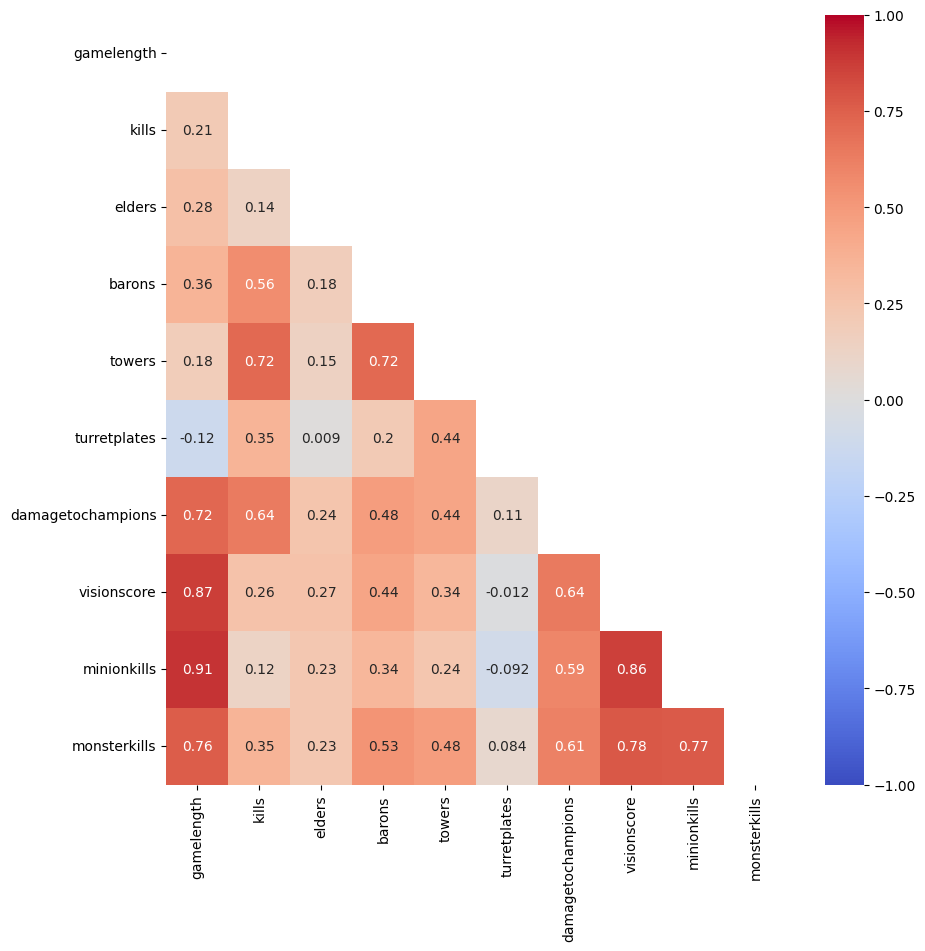

In [31]:
corr_heatmap(xtrain_std_all[features[important_features_idx]])

PCA

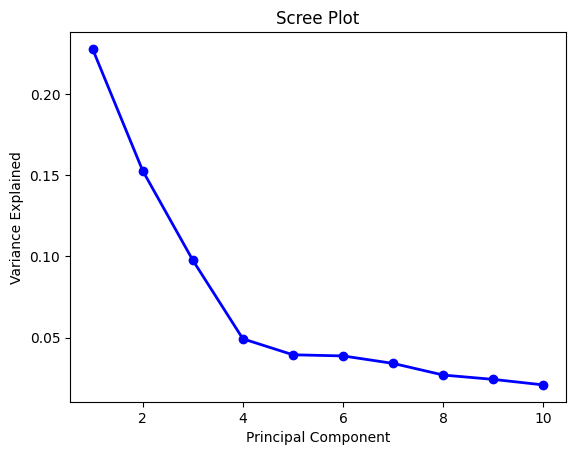

In [32]:
pca = PCA(n_components=10)
pca_fit = pca.fit(stdTrain_numeric)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [33]:
#define PCA model to use
pca = PCA(n_components=4)
#fit PCA model to data
pca.fit(stdTrain_numeric)

PCA(n_components=4)

In [42]:
pcaTrain_numeric=pd.DataFrame(pca.transform(stdTrain_numeric),index = xtrain.index)
pcaTest_numeric=pd.DataFrame(pca.transform(stdTest_numeric),index = xtest.index)
xtrain_pca_all=pd.concat([pcaTrain_numeric,xtrain[varsForPred_binary]],axis=1)
xtest_pca_all=pd.concat([pcaTest_numeric,xtest[varsForPred_binary]],axis=1)

In [35]:
loadings = pd.DataFrame(pca.components_.T, index=stdTrain_numeric.columns)

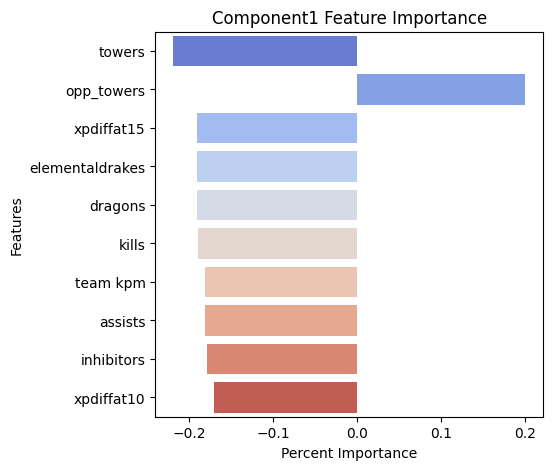

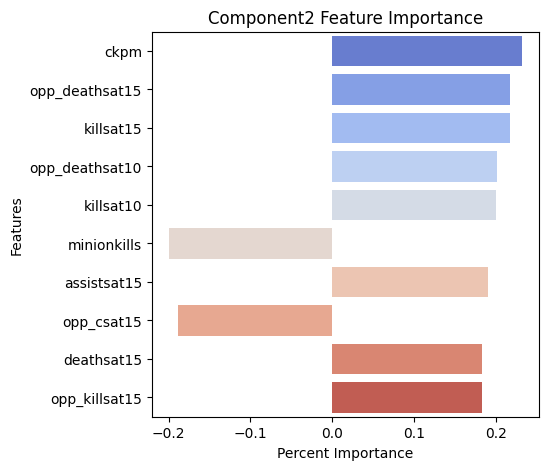

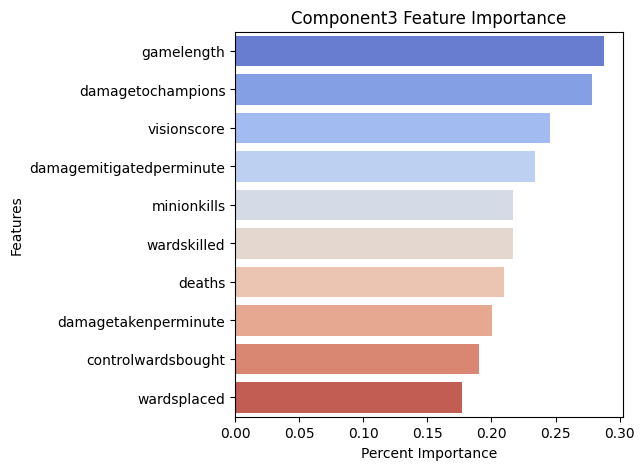

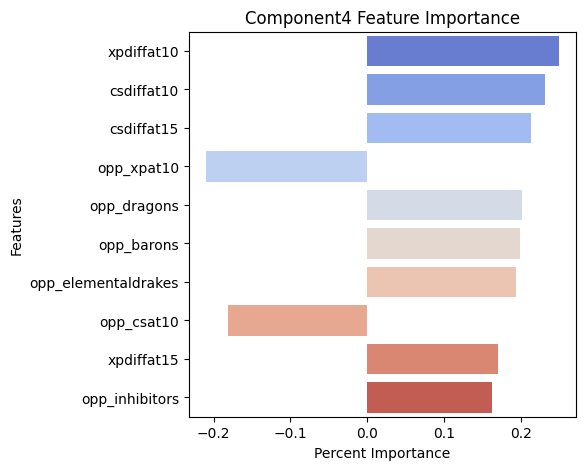

In [36]:
def drawLoadings(componentIndex, loadingsMatrix):
    feature_idx = abs(loadingsMatrix[componentIndex]).sort_values(ascending=False).index[:10]
    feature_importance = loadingsMatrix[componentIndex][feature_idx].values
    # Create bar plot of feature importances to components
    fig, ax = plt.subplots(figsize=(5,5))

    sns.barplot(x=feature_importance, y=feature_idx, palette='coolwarm', ax=ax, orient='h')

    ax.set_title(f'Component{componentIndex + 1} Feature Importance')
    ax.set_xlabel('Percent Importance')
    ax.set_ylabel('Features')
    return True
for componentIndex in np.arange(pca.n_components_):
    drawLoadings(componentIndex, loadings)

In [37]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

In [38]:
# Visualize 3 principal components
fig = px.scatter_3d(pcaTrain_numeric[[0,1,2]], x=0, y=1, z=2, height=500, width=1000)
fig.update_layout(showlegend=False,
                  scene_camera=dict(up=dict(x=0, y=0, z=1),
                                    center=dict(x=0, y=0, z=-0.1),
                                    eye=dict(x=1.5, y=-1.4, z=0.5)),
                  margin=dict(l=0, r=0, b=0, t=0),
                  scene=dict(xaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             yaxis=dict(backgroundcolor='white',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10)),
                             zaxis=dict(backgroundcolor='lightgrey',
                                        color='black',
                                        gridcolor='#f0f0f0',
                                        title_font=dict(size=10),
                                        tickfont=dict(size=10))))
fig.update_traces(marker=dict(size=3, line=dict(color='black', width=0.1)))

pac_transformed_data_mean = pcaTrain_numeric[[0,1,2]].mean(axis=0)
for length, vector in zip(pca.explained_variance_[:3], pca.components_[:3]):
    v = vector * 3 * np.sqrt(length)
    #draw_vector(pca.mean_, pca.mean_ + v)

fig.show()

Regression after PCA

In [47]:
# Linear Regression
xtrain_pca_all.columns = xtrain_pca_all.columns.astype(str)
xtest_pca_all.columns = xtest_pca_all.columns.astype(str)
reg = LinearRegression().fit(xtrain_pca_all, ytrain)
ypred=reg.predict(xtest_pca_all)
print('r2:',r2_score(ytest,ypred))
print('mse:',mean_squared_error(ytest,ypred))

r2: 0.9091097753807622
mse: 12133796.813344046


In [49]:
pd.DataFrame(reg.coef_,index=xtrain_pca_all.columns,columns=['coef']).T

,0,1,2,3,firstblood,firstdragon,firstherald,firstbaron,firsttower,firstmidtower,firsttothreetowers
coef,-1624.811671,-1146.951833,2902.236057,-35.704075,222.925143,-728.291845,324.725239,1402.779273,144.740133,-142.964164,242.994018


In [50]:
# Lasso Regression with GridSearch
pipeline = Pipeline([
                     ('model',Lasso())
])


search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(300,450,10)},
                      cv = 5,
                      scoring={"R2": 'r2', "mse": 'neg_root_mean_squared_error'},
                      refit='R2',
                      verbose=3
                      )

search.fit(xtrain_pca_all, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END model__alpha=300; R2: (test=0.909) mse: (test=-3458.821) total time=   0.0s
[CV 2/5] END model__alpha=300; R2: (test=0.900) mse: (test=-3605.307) total time=   0.0s
[CV 3/5] END model__alpha=300; R2: (test=0.905) mse: (test=-3566.036) total time=   0.0s
[CV 4/5] END model__alpha=300; R2: (test=0.902) mse: (test=-3587.211) total time=   0.0s
[CV 5/5] END model__alpha=300; R2: (test=0.903) mse: (test=-3566.888) total time=   0.0s
[CV 1/5] END model__alpha=310; R2: (test=0.909) mse: (test=-3458.790) total time=   0.0s
[CV 2/5] END model__alpha=310; R2: (test=0.900) mse: (test=-3605.502) total time=   0.1s
[CV 3/5] END model__alpha=310; R2: (test=0.905) mse: (test=-3566.612) total time=   0.0s
[CV 4/5] END model__alpha=310; R2: (test=0.902) mse: (test=-3587.494) total time=   0.0s
[CV 5/5] END model__alpha=310; R2: (test=0.903) mse: (test=-3567.313) total time=   0.0s
[CV 1/5] END model__alpha=320; R2: (test=0.909) m

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420,
       430, 440])},
             refit='R2',
             scoring={'R2': 'r2', 'mse': 'neg_root_mean_squared_error'},
             verbose=3)

In [51]:
search.best_params_

{'model__alpha': 300}

In [52]:
coefficients = search.best_estimator_.named_steps['model'].coef_
r2 = search.best_score_
importance = np.abs(coefficients)
print(r2)

0.9040894157845134


In [53]:
features = xtrain_pca_all.columns
important_features_idx = np.where(importance > 0)[0]
res = {features[i]: coefficients[i] for i in np.array(important_features_idx)}
res

{'0': -1728.403732284291, '1': -1109.4538582120585, '2': 2839.0369071974183}

In [54]:
ypred=search.best_estimator_.predict(xtest_pca_all)
print('r2:',r2_score(ytest,ypred))
print('mse:',mean_squared_error(ytest,ypred))

r2: 0.9055830049905229
mse: 12604618.791194273


**Classification**

Logistic regression

In [58]:
data_4 = RandomPickOne(data_3)

# create new colormap
colorlist=[blue_cmap(0.1),"white",red_cmap(0.5)]
newcmap = LinearSegmentedColormap.from_list('testCmap', colors=colorlist, N=1000)

In [59]:
def runLogisticReg(dataFrame):
    predVars_final = [var for var in binaryVars+numericVars if var != "result"]
    # if only the last 30 predictors
    # predVars_final = numericVars[-30:]
    x = data_4[predVars_final]
    y = data_4["result"]
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=3108)
    lg = LogisticRegressionCV()
    logisModel = lg.fit(xtrain, ytrain)
    weight = logisModel.coef_[0]
    weightsWithLabel = pd.Series(weight, index = predVars_final)
    importance = abs(weight)
    importanceWithLabel_sorted = pd.Series(importance, index = predVars_final).sort_values(ascending = False)
    weightsWithLabel_sorted = weightsWithLabel[importanceWithLabel_sorted[:10].index]

    # accuracy & AUC
    ypred = logisModel.predict(xtest)
    accuracy = accuracy_score(ypred, ytest)
    probs = logisModel.predict_proba(xtest)[:,1]
    precision, recall, thresholds = precision_recall_curve(ytest, probs)
    fpr, tpr, thresholds = roc_curve(ytest, probs)
    AreaUnderPR = auc(recall, precision)
    AreaUnderROC = auc(fpr, tpr)

    # Confusion_Matrix & ROC curve
    fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout = True,figsize = (10, 5))
    axes[0].plot(fpr, tpr, color=plt.cm.coolwarm(0))
    xx=np.linspace(0, 1, 100)
    axes[0].plot(xx, xx, color=plt.cm.coolwarm_r(0), linestyle = '--')
    axes[0].set_xlabel("FPR")
    axes[0].set_ylabel("TPR")
    axes[0].set_title("Auc ={}".format(auc(fpr, tpr)))
    con = ConfusionMatrixDisplay(confusion_matrix(ytest, ypred), display_labels = logisModel.classes_)
    con.plot(cmap=newcmap,ax=axes[1])

    print(f'weight: {weightsWithLabel_sorted}, accuracy: {accuracy}, AreaUnderPR: {AreaUnderPR}, AreaUnderROC: {AreaUnderROC}')
    return weightsWithLabel_sorted, accuracy, AreaUnderPR, AreaUnderROC

weight: minionkills            -0.009804
earned gpm              0.006669
dpm                     0.004493
visionscore             0.003565
damagetakenperminute   -0.002792
deaths                 -0.002292
opp_towers             -0.001631
assists                 0.001545
wardskilled             0.001531
controlwardsbought      0.001231
dtype: float64, accuracy: 0.981029810298103, AreaUnderPR: 0.9973083313879005, AreaUnderROC: 0.9969102358281015


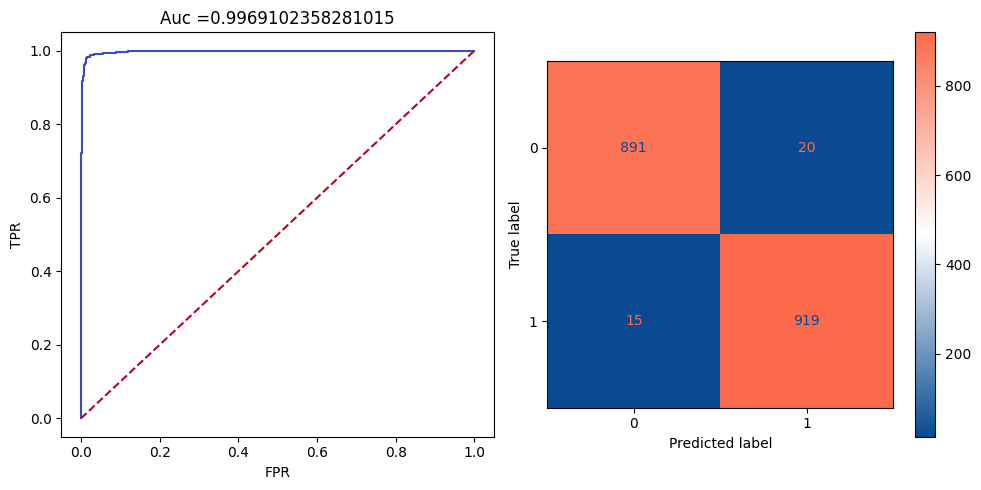

In [60]:
weightsWithLabel_sorted, accuracy, AreaUnderPR, AreaUnderROC = runLogisticReg(data_4)

Random Forest

In [61]:
varsForClas = [var for var in allFeatures if (var not in textVars)  & (var != 'result')]
xtrain, xtest, ytrain, ytest = train_test_split(data_4[varsForClas], data_4['result'],test_size=0.2, random_state=3108)
# Select numeric vars to be standardized
varsForClas_numeric = [var for var in varsForClas if var not in binaryVars] #81
varsForClas_binary = [var for var in binaryVars if var != 'result'] #7

# standard scaler_fit to training data
scaler = StandardScaler().fit(xtrain[varsForClas_numeric])
# generate standardized numeric datasets for xtrain & xtest
stdTrain_numeric = pd.DataFrame(scaler.transform(xtrain[varsForClas_numeric]), columns = varsForClas_numeric,index = xtrain.index)
stdTest_numeric = pd.DataFrame(scaler.transform(xtest[varsForClas_numeric]), columns = varsForClas_numeric,index = xtest.index)

# combine numberic data with binary data (xtrain & xtest)
xtrain_std_all = pd.concat([stdTrain_numeric,xtrain[varsForClas_binary]],axis=1)
xtest_std_all = pd.concat([stdTest_numeric,xtest[varsForClas_binary]],axis=1)

In [71]:
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 4)]
max_features = [round(x,2) for x in np.linspace(start = 0.2, stop = 1.0, num = 4)]
max_depth = [int(x) for x in np.arange(start=2, stop=11, step=3)]
min_samples_leaf = [int(x) for x in np.linspace(start = 100, stop = 600, num = 5)]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }

random_forest=RandomForestClassifier()
rf_grid = RandomizedSearchCV(estimator = random_forest,param_distributions = param_grid,
                             n_iter = 50, random_state= 3108,scoring="accuracy")
rf_grid.fit(xtrain_std_all, ytrain)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 5, 8],
                                        'max_features': [0.2, 0.47, 0.73, 1.0],
                                        'min_samples_leaf': [100, 225, 350, 475,
                                                             600],
                                        'n_estimators': [5, 10, 15, 20]},
                   random_state=3108, scoring='accuracy')

In [72]:
rf_grid.best_params_

{'n_estimators': 10,
 'min_samples_leaf': 100,
 'max_features': 0.47,
 'max_depth': 5,
 'bootstrap': False}

In [73]:
rf_grid.best_score_

0.9854994258417161

In [83]:
## print importance of feature
rf_model = RandomForestClassifier(n_estimators=10,max_features=0.47,max_depth=5,bootstrap=False,min_samples_leaf=100)
rf_model.fit(xtrain_std_all, ytrain)
importance = pd.DataFrame(list(zip(xtrain_std_all.columns,rf_model.feature_importances_)),
                          columns=["Feature","Importance"])
importance.sort_values(["Importance"],ascending=False).head(10)

,Feature,Importance
27,opp_towers,0.473133
30,inhibitors,0.294911
26,towers,0.115623
45,earned gpm,0.094128
31,opp_inhibitors,0.015641
2,deaths,0.004156
3,assists,0.001566
10,dragons,0.000403
84,firstbaron,0.000296
66,goldat15,0.000093


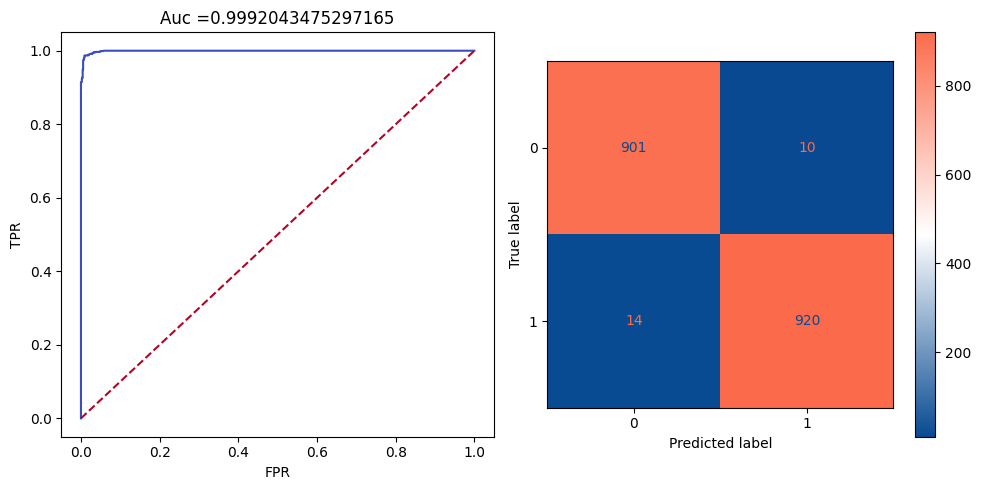

In [84]:
yhat = rf_grid.predict(xtest_std_all)
probs = rf_model.predict_proba(xtest_std_all)[:,1]
precision, recall, thresholds = precision_recall_curve(ytest, probs)
fpr, tpr, thresholds = roc_curve(ytest, probs)

fig, axes = plt.subplots(nrows=1, ncols=2, tight_layout = True,figsize = (10, 5))
axes[0].plot(fpr, tpr, color=plt.cm.coolwarm(0))
xx=np.linspace(0, 1, 100)
axes[0].plot(xx, xx, color=plt.cm.coolwarm_r(0), linestyle = '--')
axes[0].set_title("Auc ={}".format(auc(fpr, tpr)))
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
con = ConfusionMatrixDisplay(confusion_matrix(ytest, yhat), display_labels = rf_model.classes_)
con.plot(cmap=newcmap,ax=axes[1])


In [85]:
accuracy_score(ytest,yhat)

0.9869918699186991

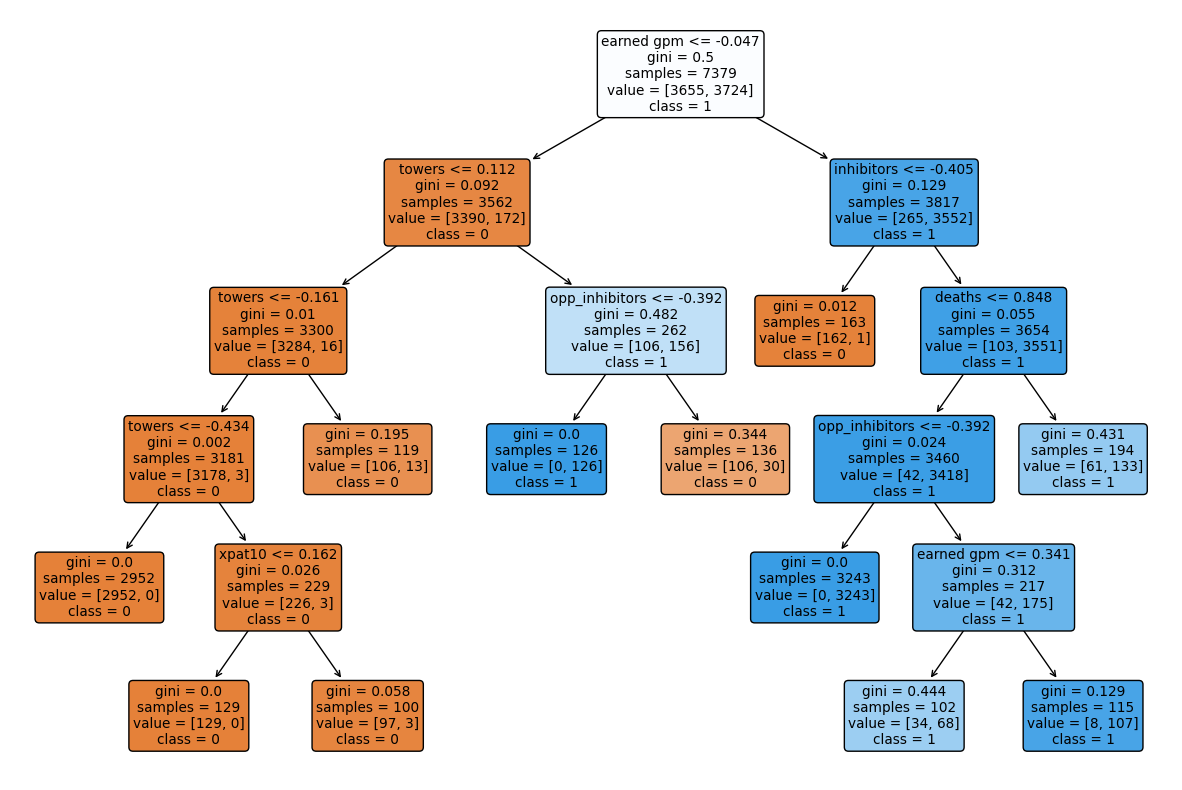

In [87]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf_model.estimators_[0],
          feature_names=xtrain_std_all.columns,
          class_names=np.array(["0","1"]),
          filled=True, impurity=True,
          rounded=True)
plt.show()